---
### Decision Tree & Random Forest
---

To visualize the decision trees that will be built in this lab session, you need to install the `graphviz`, `python-graphviz`, and `pydotplus` libraries.

We are working with a real estate dataset. The goal is to predict property prices based on environmental features. This is therefore a regression problem. For more details, one can refer to the dataset documentation.

In [21]:
import numpy as np
from sklearn.datasets import fetch_california_housing

In [22]:
data = fetch_california_housing()
X = data.data
y = data.target

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)

The argument `random_state=17` sets the seed used by the random number generator within the `train_test_split` function. This ensures that the shuﬄing of the data is reproducible across runs. It does not aﬀect all randomness globally, but only the randomness internal to that function. Using a fixed `random_state` makes it easier to compare diﬀerent models by ensuring that they are trained and tested on the same data splits.

A decision tree can be trained for this regression problem as follows:

In [24]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=0).fit(X_train, y_train)

By default, the impurity criterion used for regression is the Mean Squared Error (MSE). For each node, the split is selected randomly among those that minimize the criterion. However, for each decision tree trained in this lab, we will enforce deterministic behavior using the `random_state=0` argument.

*NB*: You can access the depth and the number of nodes of the tree `dt` using `dt.tree_.max_depth` and `dt.tree_.node_count`, respectively. You can limit the depth of the tree using the `max_depth` argument.

**Question 1.** — Define a function `tree_summary` that takes a trained decision tree as an argument and displays its training score, test score, depth, and number of nodes. Apply this function to the tree `dt` constructed above. Comment on the results.

In [25]:
def tree_summary(decision_tree, X_train, y_train, X_test, y_test):
    training_score = decision_tree.score(X_train, y_train)
    test_score     = decision_tree.score(X_test, y_test)
    depth          = decision_tree.tree_.max_depth
    nodes          = decision_tree.tree_.node_count

    print("For the provided Decision Tree:")
    print(f" - Training Score : {training_score:.2f}")
    print(f" - Test Score     : {test_score:.2f}")
    print(f" - Tree Depth     : {depth}")
    print(f" - Number of Nodes: {nodes}")

In [26]:
tree_summary(dt, X_train, y_train, X_test, y_test)

For the provided Decision Tree:
 - Training Score : 1.00
 - Test Score     : 0.62
 - Tree Depth     : 35
 - Number of Nodes: 29733


The decision tree perfectly memorizes the training data (Training Score = 1.00), but its test score is much lower (0.62), indicating strong overfitting. The tree is very deep (depth = 35) and has a huge number of nodes (29733), which confirms that it has grown almost without constraint and is too complex for good generalization.

**Question 2.** — Train a decision tree, named `dt2`, with its depth limited to 10. Observe its scores and characteristics. Comment on the results.

In [27]:
dt2 = DecisionTreeRegressor(max_depth=10, random_state=0).fit(X_train, y_train)
tree_summary(dt2, X_train, y_train, X_test, y_test)

For the provided Decision Tree:
 - Training Score : 0.85
 - Test Score     : 0.70
 - Tree Depth     : 10
 - Number of Nodes: 1559


Limiting the tree to depth 10 significantly reduced overfitting:
- The training score dropped slightly to 0.85 (no longer perfect memorization, but still good).
- The test score improved to 0.70, meaning the model generalizes better to unseen data.
- The tree is much simpler (only 1559 nodes compared to 29733 before), making it easier to interpret and less prone to noise.

In [28]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [29]:
dt3 = DecisionTreeRegressor(max_depth=3, random_state=0).fit(X_train, y_train)
features_name = data.feature_names

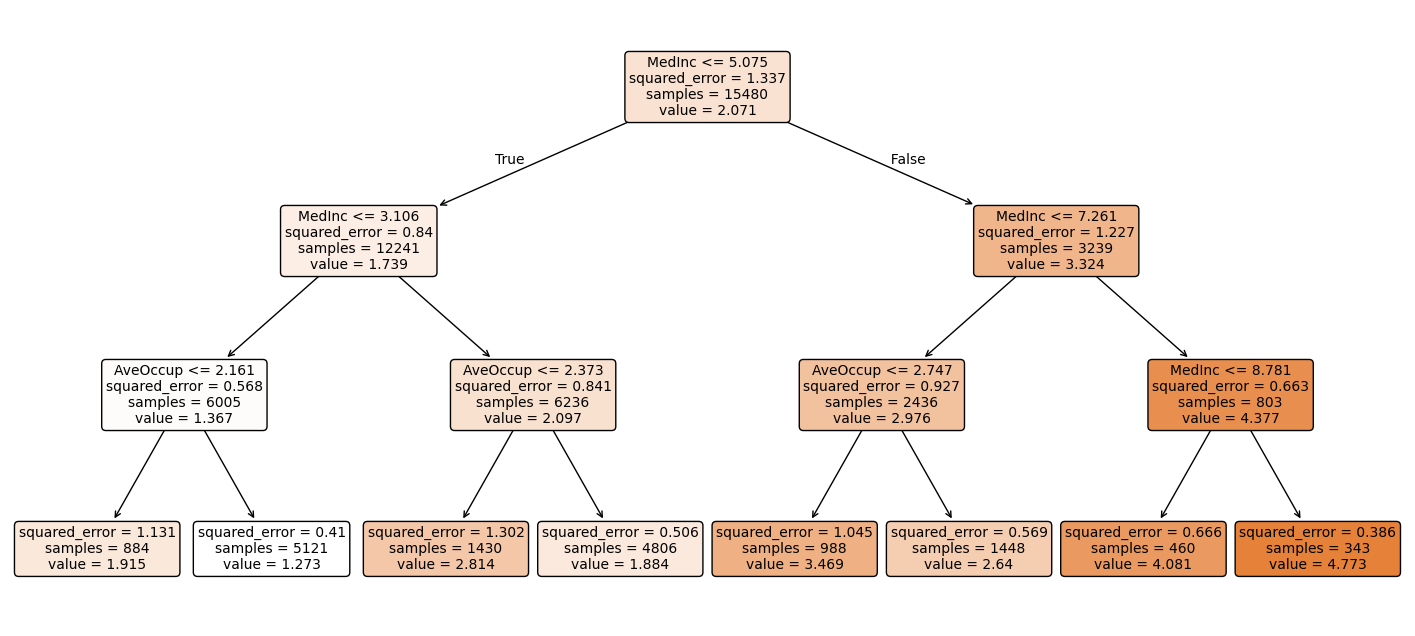

In [30]:
plt.figure(figsize=(18, 8))
plot_tree(dt3,
          filled=True,
          feature_names=features_name,
          rounded=True,
          fontsize=10)
plt.show()

**Question 3.** — Which explanatory variables are involved in the decision tree `dt3`?

In the visualized decision tree `dt3`, only two explanatory variables are involved:
- `MedInc` (Median Income)
- `AveOccup` (Average Occupancy)

The tree first splits on `MedInc`, meaning that the median income of households is the most important variable for predicting property prices. After splitting by income levels, the tree uses `AveOccup` to further split the data within the different income groups. This indicates that the average number of people per household also helps refine the prediction.

**Question 4.** — Using 10-fold cross-validation, choose the best value for the maximum depth of the decision tree.

In [53]:
from sklearn.model_selection import cross_val_score

In [54]:
# Range of depths to try
max_depth_values = range(5, 14)
# Store the mean cross-validation scores
cv_scores = []

for depth in max_depth_values:
    tree = DecisionTreeRegressor(max_depth=depth, random_state=0)
    scores = cross_val_score(tree, X_train, y_train, cv=10, scoring='r2')
    cv_scores.append(np.mean(scores))

# Find the best depth
best_depth = max_depth_values[np.argmax(cv_scores)]
print(f"Best max_depth: {best_depth}.")

Best max_depth: 9.


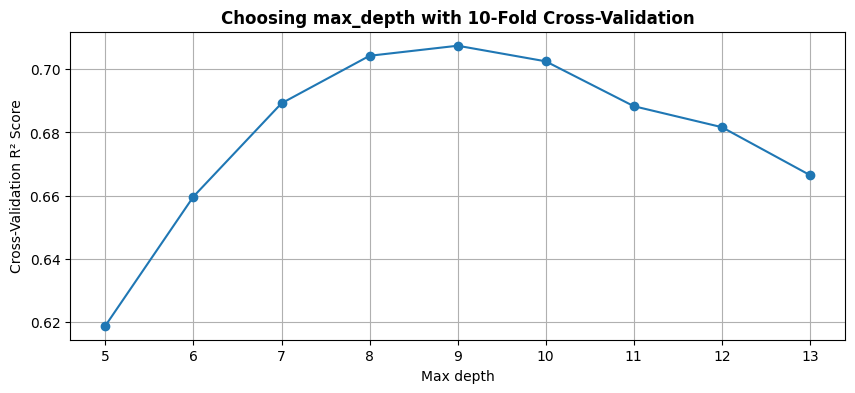

In [55]:
plt.figure(figsize=(10, 4))
plt.plot(max_depth_values, cv_scores, marker='o')
plt.xlabel('Max depth')
plt.ylabel('Cross-Validation R² Score')
plt.title('Choosing max_depth with 10-Fold Cross-Validation', fontweight='bold')
plt.grid(True)
plt.show()

The following questions aim to guide the construction of a predictor obtained by aggregating several decision trees trained on different training samples. 

More precisely, let $S = \{(X_i, Y_i)\}_{i \in [m]}$ be the original training sample, and let $n$ be the number of decision trees we want to aggregate.

For each $k \in [n]$, a sample of size $m$ is drawn:

$$
S^{(k)} = \{(X_i^{(k)}, Y_i^{(k)})\}_{i \in [m]}
$$

where each example $(X_i^{(k)}, Y_i^{(k)})$ is sampled uniformly and independently from the original dataset $S$ (this is thus a sampling with replacement).

A decision tree $\hat{f}^{(k)}$ is then trained on each sample $S^{(k)}$, and the final predictor $\hat{f}$ is obtained by averaging:

$$
\forall x \in \mathcal{X}, \quad \hat{f}(x) = \frac{1}{n} \sum_{k=1}^{n} \hat{f}^{(k)}(x)
$$

**Question 5.** — Define a function `r2_score` that takes two arrays `y_true` and `y_predict` as arguments, containing respectively the true labels and the predicted labels for a given sample. The function should return the corresponding $R^2$ score.

In [56]:
def r2_score(y_true, y_predict):
    ss_res = ((y_true - y_predict) ** 2).sum()
    ss_tot = ((y_true - y_true.mean()) ** 2).sum()
    return 1 - ss_res / ss_tot

**Question 6.** — Using the function resample, draw (with replacement) a new sample `(X_train_, y_train_)` of the same size from the training sample `(X_train, y_train)`. Since sampling is with replacement, some examples may appear multiple times in the new sample, while others may not appear at all. Train a decision tree on this new sample (with `random_state=0` and default values for the other parameters), and display its $R^2$ score using the `r2_score` function. Verify that it gives the same result as the predictor’s built-in `.score` method.

In [50]:
from sklearn.utils import resample

In [59]:
# Step 1: Resample the training data (with replacement)
X_train_, y_train_ = resample(X_train, y_train, replace=True, random_state=0)

# Step 2: Train a decision tree on the resampled data
tree = DecisionTreeRegressor(max_depth=5, random_state=0)
tree.fit(X_train_, y_train_)

# Step 3: Make predictions on the resampled data
y_pred = tree.predict(X_train_)

# Step 4: Compute the R² score using your r2_score function
r2_manual = r2_score(y_train_, y_pred)

# Step 5: Compute the R² score using the built-in .score() method
r2_builtin = tree.score(X_train_, y_train_)

# Step 6: Print both to verify they are the same
print(f"Manual R² score: {r2_manual:.5f}")
print(f"Built-in .score() R²: {r2_builtin:.5f}")

Manual R² score: 0.64852
Built-in .score() R²: 0.64852


**Question 7.** — Build 5 predictors in the same way as in the previous question, resampling `(X_train, y_train)` each time. Compute the predictions of each predictor on the test set.

In [64]:
# To store the predictions on X_test
test_predictions = []

# Build 5 trees
for i in range(5):
    # Step 1: Resample the training data
    X_train_, y_train_ = resample(X_train, y_train, replace=True, random_state=i)
    
    # Step 2: Train a decision tree on the resampled data
    tree = DecisionTreeRegressor(random_state=0)
    tree.fit(X_train_, y_train_)
    
    # Step 3: Predict on the test set
    y_pred_test = tree.predict(X_test)
    
    # Store the prediction
    test_predictions.append(y_pred_test)

**Question 8.** — Consider the predictor defined as the average of the 5 predictors built in the previous question. Compute its predictions on the test set and calculate the corresponding $R^2$ score.

**Question 9.** — Define a function `tree_aggregation` that takes an integer argument `n_trees`, trains `n_trees` decision trees as previously described, and displays the $R^2$ score of the aggregated predictor on the test set. Run this function with different values for `n_trees` and try to achieve a better score.

The procedure that involves building a new training sample using uniform sampling with replacement is called **bootstrap**. The process of aggregating several predictors trained on bootstrap samples is called **bagging** (short for bootstrap aggregating). In the special case of decision trees, bagging is also known as a **random forest**. Scikit-learn provides a built-in implementation of the random forest algorithm, which can be used as follows:

In [58]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=5).fit(X_train, y_train)

**Question 10.** — Compare the results obtained using the `tree_aggregation` function with those from the built-in Scikit-learn algorithm.